In [ ]:
##### Copyright 2020 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # 设置日志级别为ERROR，以减少警告信息
# 禁用 Gemini 的底层库（gRPC 和 Abseil）在初始化日志警告
os.environ["GRPC_VERBOSITY"] = "ERROR"
os.environ["GLOG_minloglevel"] = "3"  # 0: INFO, 1: WARNING, 2: ERROR, 3: FATAL
os.environ["GLOG_minloglevel"] = "true"
import logging
import tensorflow as tf
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
!export TF_FORCE_GPU_ALLOW_GROWTH=true
from pathlib import Path

temp_dir = Path(".temp")
temp_dir.mkdir(parents=True, exist_ok=True)

# 使用 Actor-Critic 方法玩 CartPole 游戏


<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://tensorflow.google.cn/tutorials/reinforcement_learning/actor_critic"><img src="https://tensorflow.google.cn/images/tf_logo_32px.png">在 TensorFlow.org 上查看</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/reinforcement_learning/actor_critic.ipynb"><img src="https://tensorflow.google.cn/images/colab_logo_32px.png">在 Google Colab 中运行</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/reinforcement_learning/actor_critic.ipynb"><img src="https://tensorflow.google.cn/images/GitHub-Mark-32px.png">在 GitHub 上查看源代码</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/zh-cn/tutorials/reinforcement_learning/actor_critic.ipynb"><img src="https://tensorflow.google.cn/images/download_logo_32px.png">下载笔记本</a></td>
</table>

本教程演示如何使用 TensorFlow 实现 [Actor-Critic](https://papers.nips.cc/paper/1786-actor-critic-algorithms.pdf) 方法以在 [Open AI Gym](https://www.gymlibrary.dev/) [`CartPole-v0`](https://www.gymlibrary.dev/environments/classic_control/cart_pole/) 环境中训练代理。假定读者对[（深度）强化学习](https://papers.nips.cc/paper/1713-policy-gradient-methods-for-reinforcement-learning-with-function-approximation.pdf)的[策略梯度方法](https://en.wikipedia.org/wiki/Deep_reinforcement_learning)有所了解。


**Actor-Critic 方法**

Actor-Critic 方法是表示与价值函数无关的策略函数的[时间差分 (TD) 学习](https://en.wikipedia.org/wiki/Temporal_difference_learning)方法。

策略函数（或策略）返回代理基于给定状态可以采取的动作的概率分布。价值函数确定从给定状态开始并在此后永远根据特定策略运行的代理的预期回报。

在 Actor-Critic 方法中，策略被称为*行动者*，它根据给定状态提出一组可能的动作，而估算的价值函数则被称为*评价者*，它根据给定的策略评估*行动者*所采取的动作。

在本教程中，将使用一个具有两个输出的神经网络来表示*行动者*和*评价者*。


**`CartPole-v0`**

在 [`CartPole-v0` 环境](https://www.gymlibrary.dev/environments/classic_control/cart_pole/)中，将长杆连接到沿无摩擦轨道移动的小车上。长杆开始时是直立的，代理的目标是通过对小车施加 `-1` 或 `+1` 的力来防止其倒下。对于长杆保持直立的每个时间步骤，奖励为 `+1`。当 1) 长杆与垂直方向的夹角超过 15 度或 2) 小车从中心移出超过 2.4 个单位时，片段结束。

<center>
  <pre data-md-type="custom_pre">&lt;figure&gt;
    &lt;image src="https://tensorflow.org/tutorials/reinforcement_learning/images/cartpole-v0.gif"&gt;
    &lt;figcaption&gt;
      Trained actor-critic model in Cartpole-v0 environment
    &lt;/figcaption&gt;
  &lt;/figure&gt;</pre>
</center>


在 100 次连续试验中，当片段的平均总奖励达到 195 时，问题被视为“已解决”。

## 安装

导入必要的软件包并配置全局设置。


In [2]:
!pip install -q gymnasium[classic_control]
!pip install -q pyglet

In [3]:
%%bash
# Install additional packages for visualization
sudo apt-get install -y python-opengl > /dev/null 2>&1
pip install git+https://github.com/tensorflow/docs > /dev/null 2>&1

In [5]:
import collections
import gymnasium as gym
import numpy as np
import statistics
import tensorflow as tf
import tqdm

from matplotlib import pyplot as plt
from tensorflow.keras import layers
from typing import Any, List, Sequence, Tuple


# Create the environment
env = gym.make("CartPole-v1")

# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Small epsilon value for stabilizing division operations
eps = np.finfo(np.float32).eps.item()

## 模型

将使用分别生成动作概率和评价者值的神经网络来对*行动者*和*评价者*进行建模。本教程使用模型子类化来定义模型。

在前向传递过程中，模型将状态作为输入，并将输出动作概率和评价者价值 $V$，后者会对与状态相关的[价值函数](https://spinningup.openai.com/en/latest/spinningup/rl_intro.html#value-functions)进行建模。目标是训练一个基于可使预期[回报](https://spinningup.openai.com/en/latest/spinningup/rl_intro.html#reward-and-return)最大化的策略 $\pi$ 来选择动作的模型。

对于 `CartPole-v0`，有四个值来表示状态：小车位置、小车速度、长杆角度和长杆速度。代理可以采取两种动作分别将小车向左 (`0`) 和向右 (`1`) 推。

有关更多信息，请参阅 [Gym 的 Cart Pole 文档页面](https://www.gymlibrary.dev/environments/classic_control/cart_pole/)和 Barto、Sutton 和 Anderson (1983) 所著的 [*Neuronlike adaptive elements that can solve difficult learning control problems*](http://www.derongliu.org/adp/adp-cdrom/Barto1983.pdf)。


In [6]:
class ActorCritic(tf.keras.Model):
  """Combined actor-critic network."""

  def __init__(
      self, 
      num_actions: int, 
      num_hidden_units: int):
    """Initialize."""
    super().__init__()

    self.common = layers.Dense(num_hidden_units, activation="relu")
    self.actor = layers.Dense(num_actions)
    self.critic = layers.Dense(1)

  def call(self, inputs: tf.Tensor) -> Tuple[tf.Tensor, tf.Tensor]:
    x = self.common(inputs)
    return self.actor(x), self.critic(x)

In [7]:
num_actions = env.action_space.n  # 2
num_hidden_units = 128

model = ActorCritic(num_actions, num_hidden_units)

## 训练代理

要训练代理，您将按照以下步骤操作：

1. 在环境上运行代理以收集每个片段的训练数据。
2. 计算每个时间步骤的预期回报。
3. 计算组合的 Actor-Critic 模型的损失。
4. 计算梯度并更新网络参数。
5. 重复第 1-4 步，直至达到成功标准或最大片段数。


### 1. 收集训练数据

与监督学习中一样，为了训练 Actor-Critic 模型，我们需要拥有训练数据。但是，为了收集此类数据，需要在环境中“运行”模型。

我们收集每个片段的训练数据。随后，在每个时间步骤，将在环境的状态下运行模型的前向传递，以便基于由模型权重参数化的当前策略来生成动作概率和评价者价值。

将根据模型生成的动作概率对下一个动作进行采样，然后将其应用于环境，这会生成下一个状态和奖励。

此过程在 `run_episode` 函数中实现，该函数使用 TensorFlow 运算，以便稍后可以将其编译为 TensorFlow 计算图以实现更快的训练。请注意，需要使用 `tf.TensorArray` 来支持可变长度数组上的 Tensor 迭代。

In [8]:
# Wrap Gym's `env.step` call as an operation in a TensorFlow function.
# This would allow it to be included in a callable TensorFlow graph.

def env_step(action: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
  """Returns state, reward and done flag given an action."""

  state, reward, done, truncated, info = env.step(action)
  return (state.astype(np.float32), 
          np.array(reward, np.int32), 
          np.array(done, np.int32))


def tf_env_step(action: tf.Tensor) -> List[tf.Tensor]:
  return tf.numpy_function(env_step, [action], 
                           [tf.float32, tf.int32, tf.int32])

In [9]:
def run_episode(
    initial_state: tf.Tensor,  
    model: tf.keras.Model, 
    max_steps: int) -> Tuple[tf.Tensor, tf.Tensor, tf.Tensor]:
  """Runs a single episode to collect training data."""

  action_probs = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
  values = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
  rewards = tf.TensorArray(dtype=tf.int32, size=0, dynamic_size=True)

  initial_state_shape = initial_state.shape
  state = initial_state

  for t in tf.range(max_steps):
    # Convert state into a batched tensor (batch size = 1)
    state = tf.expand_dims(state, 0)
  
    # Run the model and to get action probabilities and critic value
    action_logits_t, value = model(state)
  
    # Sample next action from the action probability distribution
    action = tf.random.categorical(action_logits_t, 1)[0, 0]
    action_probs_t = tf.nn.softmax(action_logits_t)

    # Store critic values
    values = values.write(t, tf.squeeze(value))

    # Store log probability of the action chosen
    action_probs = action_probs.write(t, action_probs_t[0, action])
  
    # Apply action to the environment to get next state and reward
    state, reward, done = tf_env_step(action)
    state.set_shape(initial_state_shape)
  
    # Store reward
    rewards = rewards.write(t, reward)

    if tf.cast(done, tf.bool):
      break

  action_probs = action_probs.stack()
  values = values.stack()
  rewards = rewards.stack()
  
  return action_probs, values, rewards

### 2. 计算预期回报

将在一个片段内收集到的每个时间步骤的奖励序列 $t$, ${r_{t}}^{T}{em0}{t=1}$ 转换为预期回报序列 ${G{/em0}{t}}^{T}_{t=1}$，其中，奖励的总和来自于当前时间步骤 $t$ 到 $T$，每个奖励都会乘以按指数衰减的折扣因子 $\gamma$：

$$G_{t} = \sum^{T}*{t'=t} \gamma^{t'-t}r*{t'}$$

由于 $\gamma\in(0,1)$，距离当前时间步骤更远的奖励的权重较小。

从直觉上看，预期回报只是意味着现在的回报要优于以后的回报。从数学意义上讲，这是为了确保奖励的总和收敛。

为了稳定训练，我们还将生成的回报序列标准化（即均值和单位标准差为零）。


In [10]:
def get_expected_return(
    rewards: tf.Tensor, 
    gamma: float, 
    standardize: bool = True) -> tf.Tensor:
  """Compute expected returns per timestep."""

  n = tf.shape(rewards)[0]
  returns = tf.TensorArray(dtype=tf.float32, size=n)

  # Start from the end of `rewards` and accumulate reward sums
  # into the `returns` array
  rewards = tf.cast(rewards[::-1], dtype=tf.float32)
  discounted_sum = tf.constant(0.0)
  discounted_sum_shape = discounted_sum.shape
  for i in tf.range(n):
    reward = rewards[i]
    discounted_sum = reward + gamma * discounted_sum
    discounted_sum.set_shape(discounted_sum_shape)
    returns = returns.write(i, discounted_sum)
  returns = returns.stack()[::-1]

  if standardize:
    returns = ((returns - tf.math.reduce_mean(returns)) / 
               (tf.math.reduce_std(returns) + eps))

  return returns

### 3. Actor-Critic 损失

由于使用的是混合 Actor-Critic 模型，会选择将行动者损失与评价者损失相结合的损失函数来进行训练，如下所示：

$$L = L_{actor} + L_{critic}$$

#### 行动者损失

行动者损失基于[将评价者作为状态相关基线的策略梯度](https://www.youtube.com/watch?v=EKqxumCuAAY&t=62m23s)，并使用单个样本（每个片段）的估计值进行计算。

$$L_{actor} = -\sum^{T}*{t=1} log\pi*{\theta}(a_{t} | s_{t})[G(s_{t}, a_{t})  - V^{\pi}*{\theta}(s*{t})]$$

其中：

- $T$：每个片段的时间步骤数，各个片段可能有所不同
- $s_{t}$：时间步骤 $t$ 的状态
- $a_{t}$：对于给定状态 $s$，在时间步骤 $t$ 选择的动作
- $\pi_{\theta}$：由 $\theta$ 参数化的策略（行动者）
- $V^{\pi}_{\theta}$：由 $\theta$ 参数化的价值函数（评价者）
- $G = G_{t}$：对于给定状态，在时间步骤 $t$ 采取的动作对的预期回报

向总和添加一个负数项，因为我们希望通过最大程度减少组合损失来尽可能提高产生更高奖励的动作的概率。

<br>

##### 优势

$L_{actor}$ 公式中的 $G - V$ 项称为[优势](https://spinningup.openai.com/en/latest/spinningup/rl_intro.html#advantage-functions)，它表示针对给定的特定状态采取的动作要比根据用于该状态的策略 $\pi$ 选择的随机动作好得多。

尽管可以排除基线，但这可能会导致训练期间出现高方差。选择评价者 $V$ 作为基线的好处是，它可以训练得尽可能接近 $G$，从而降低方差。

此外，在没有评价者时，该算法将尝试根据预期回报来提高针对特定状态采取的动作的概率，如果动作之间的相对概率保持相同，可能不会有太大的区别。

例如，假设给定状态的两个动作将产生相同的预期回报。在没有评价者时，该算法将基于目标 $J$ 尝试提高这些动作的概率。在有评价者时，结果可能是不存在优势 ($G - V = 0$)，这对于提高动作的概率没有任何益处，并且算法会将梯度设置为零。

<br>

#### The Critic loss

可以将 $V$ 训练得尽可能接近 $G$，这样便可将评价者损失设置为具有以下损失函数的回归问题：

$$L_{critic} = L_{\delta}(G, V^{\pi}_{\theta})$$

其中 $L_{\delta}$ 是 [Huber 损失](https://en.wikipedia.org/wiki/Huber_loss)，它对数据中离群值的敏感性低于平方误差损失。


In [11]:
huber_loss = tf.keras.losses.Huber(reduction=tf.keras.losses.Reduction.SUM)

def compute_loss(
    action_probs: tf.Tensor,  
    values: tf.Tensor,  
    returns: tf.Tensor) -> tf.Tensor:
  """Computes the combined Actor-Critic loss."""

  advantage = returns - values

  action_log_probs = tf.math.log(action_probs)
  actor_loss = -tf.math.reduce_sum(action_log_probs * advantage)

  critic_loss = huber_loss(values, returns)

  return actor_loss + critic_loss

### 4. 定义训练步骤以更新参数

将上述所有步骤组合成一个每个片段都会运行的训练步骤。使用 `tf.GradientTape` 上下文来执行损失函数之前的所有步骤，以实现自动微分。

本教程使用 Adam 优化器将梯度应用于模型参数。

无折扣奖励的总和 `` 也会在此步骤中计算。此值稍后将用于评估是否满足成功标准。

将 `tf.function` 上下文应用于 `train_step` 函数，这样便可将其编译为可调用的 TensorFlow 计算图，进而可以将训练速度提高 10 倍。


In [12]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)


@tf.function
def train_step(
    initial_state: tf.Tensor, 
    model: tf.keras.Model, 
    optimizer: tf.keras.optimizers.Optimizer, 
    gamma: float, 
    max_steps_per_episode: int) -> tf.Tensor:
  """Runs a model training step."""

  with tf.GradientTape() as tape:

    # Run the model for one episode to collect training data
    action_probs, values, rewards = run_episode(
        initial_state, model, max_steps_per_episode) 

    # Calculate the expected returns
    returns = get_expected_return(rewards, gamma)

    # Convert training data to appropriate TF tensor shapes
    action_probs, values, returns = [
        tf.expand_dims(x, 1) for x in [action_probs, values, returns]] 

    # Calculate the loss values to update our network
    loss = compute_loss(action_probs, values, returns)

  # Compute the gradients from the loss
  grads = tape.gradient(loss, model.trainable_variables)

  # Apply the gradients to the model's parameters
  optimizer.apply_gradients(zip(grads, model.trainable_variables))

  episode_reward = tf.math.reduce_sum(rewards)

  return episode_reward

### 5. 运行训练循环

通过运行训练步骤来执行训练，直到达到成功标准或最大片段数。

使用队列保存片段奖励的运行记录。达到 100 次试验后，将删除队列尾端（左侧）的最早奖励，同时将最新奖励添加到队列头部（右侧）。此外，还会保持奖励的运行总和以提高计算效率。

根据您的运行时，训练可以在不到一分钟的时间内完成。

In [13]:
%%time

min_episodes_criterion = 100
max_episodes = 10000
max_steps_per_episode = 500

# `CartPole-v1` is considered solved if average reward is >= 475 over 500 
# consecutive trials
reward_threshold = 475
running_reward = 0

# The discount factor for future rewards
gamma = 0.99

# Keep the last episodes reward
episodes_reward: collections.deque = collections.deque(maxlen=min_episodes_criterion)

t = tqdm.trange(max_episodes)
for i in t:
    initial_state, info = env.reset()
    initial_state = tf.constant(initial_state, dtype=tf.float32)
    episode_reward = int(train_step(
        initial_state, model, optimizer, gamma, max_steps_per_episode))
    
    episodes_reward.append(episode_reward)
    running_reward = statistics.mean(episodes_reward)
  

    t.set_postfix(
        episode_reward=episode_reward, running_reward=running_reward)
  
    # Show the average episode reward every 10 episodes
    if i % 10 == 0:
      pass # print(f'Episode {i}: average reward: {avg_reward}')
  
    if running_reward > reward_threshold and i >= min_episodes_criterion:  
        break

print(f'\nSolved at episode {i}: average reward: {running_reward:.2f}!')

 15%|█▍        | 1458/10000 [11:21<1:06:34,  2.14it/s, episode_reward=500, running_reward=478]


Solved at episode 1458: average reward: 478.01!
CPU times: user 27min 22s, sys: 2min 6s, total: 29min 28s
Wall time: 11min 21s


## 可视化

训练后，最好呈现模型在环境中的表现。您可以运行下面的单元来生成模型的一次片段运行的 GIF 动画。请注意，需要为 Gym 安装附加软件包，以便在 Colab 中正确呈现环境图像。

In [15]:
# Render an episode and save as a GIF file

from IPython import display as ipythondisplay
from PIL import Image

render_env = gym.make("CartPole-v1", render_mode='rgb_array')

def render_episode(env: gym.Env, model: tf.keras.Model, max_steps: int): 
  state, info = env.reset()
  state = tf.constant(state, dtype=tf.float32)
  screen = env.render()
  images = [Image.fromarray(screen)]
 
  for i in range(1, max_steps + 1):
    state = tf.expand_dims(state, 0)
    action_probs, _ = model(state)
    action = np.argmax(np.squeeze(action_probs))

    state, reward, done, truncated, info = env.step(action)
    state = tf.constant(state, dtype=tf.float32)

    # Render screen every 10 steps
    if i % 10 == 0:
      screen = env.render()
      images.append(Image.fromarray(screen))
  
    if done:
      break
  
  return images


# Save GIF image
images = render_episode(render_env, model, max_steps_per_episode)
image_file = temp_dir/'cartpole-v1.gif'
# loop=0: loop forever, duration=1: play each frame for 1ms
images[0].save(
    image_file, save_all=True, append_images=images[1:], loop=0, duration=1)


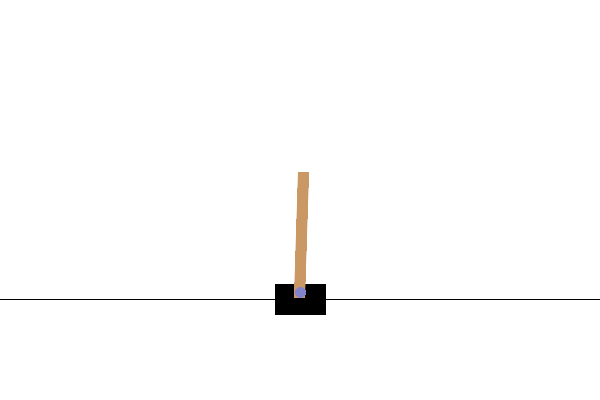

In [16]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(image_file)

## 后续步骤

本教程演示了如何使用 Tensorflow 实现 Actor-Critic 方法。

接下来，您可以尝试在 Gym 的不同环境中训练模型。

有关 Actor-Critic 方法和 Cartpole-v0 问题的其他信息，您可以参考以下资源：

- [Actor-Critic 方法](https://hal.inria.fr/hal-00840470/document)
- [Actor-Critic 讲座 (CAL)](https://www.youtube.com/watch?v=EKqxumCuAAY&list=PLkFD6_40KJIwhWJpGazJ9VSj9CFMkb79A&index=7&t=0s)
- [Cart Pole 学习控制问题 [Barto 等人，1983 年]](http://www.derongliu.org/adp/adp-cdrom/Barto1983.pdf)

有关 TensorFlow 中的更多强化学习示例，您可以查看以下资源：

- [强化学习代码示例 (keras.io)](https://keras.io/examples/rl/)
- [TF-Agents 强化学习库](https://tensorflow.google.cn/agents)
